In [1]:
%pip install tensorflow
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\julia\Documents\Uni_lokal\ML\Repositories\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [14]:
#load data
train_df = pd.read_csv("C:/Users/julia/Documents/Uni_lokal/ML/guelfem/gülfem_train_final.csv", sep=';')
val_df = pd.read_csv("C:/Users/julia/Documents/Uni_lokal/ML/guelfem/gülfem_validation_final.csv", sep=';')
test_df = pd.read_csv("C:/Users/julia/Documents/Uni_lokal/ML/guelfem/gülfem_test_final.csv", sep=';')
print(train_df.head())

        Datum  warengruppe       id      umsatz  Bewoelkung  Temperatur  \
0  2013-07-01            1  1307011  148.828353         6.0     17.8375   
1  2013-07-01            2  1307012  535.856285         6.0     17.8375   
2  2013-07-01            3  1307013  201.198426         6.0     17.8375   
3  2013-07-01            4  1307014   65.890169         6.0     17.8375   
4  2013-07-01            5  1307015  317.475875         6.0     17.8375   

   Windgeschwindigkeit  Wettercode  KielerWoche  school_holiday  \
0                 15.0        20.0            0               1   
1                 15.0        20.0            0               1   
2                 15.0        20.0            0               1   
3                 15.0        20.0            0               1   
4                 15.0        20.0            0               1   

   public_holiday  Wochentag  wettercode_knn  wettercode_agg  temp_category  
0               0        0.0            20.0             2.0        

In [15]:
#datetime
train_df['Datum'] = pd.to_datetime(train_df['Datum'])
val_df['Datum'] = pd.to_datetime(val_df['Datum'])
test_df['Datum'] = pd.to_datetime(test_df['Datum'])


for df in [train_df, val_df, test_df]:
    df['year'] = df['Datum'].dt.year
    df['month'] = df['Datum'].dt.month
    df['day'] = df['Datum'].dt.day
    df.drop('Datum', axis=1, inplace=True)

# One-hot encoding for columns: 'warengruppe', 'KielerWoche', 'Wochentag', 
# wettercode_agg, 'wettercode_knn', 'temp_category', school_holiday, public_holiday

features = ['warengruppe', 'KielerWoche', 'Wochentag', 
            'wettercode_agg', 'wettercode_knn', 'temp_category', 
            'school_holiday', 'public_holiday']
for df in [train_df, val_df, test_df]:
    df = pd.get_dummies(df, columns=features, drop_first=False, dtype=int) #keep false as NN can work with multicollinearity
    

all_columns = set(train_df.columns) | set(val_df.columns) | set(test_df.columns)

for df in [train_df, val_df, test_df]:
    for col in all_columns:
        if col not in df.columns:
            df[col] = 0

train_df = train_df[sorted(train_df.columns)]
val_df   = val_df[sorted(val_df.columns)]
test_df  = test_df[sorted(test_df.columns)]

#drop rows with na values
train_df = train_df.dropna().reset_index(drop=True)
val_df = val_df.dropna().reset_index(drop=True)

#drop rows with na values in column wettercode_knn
cols_to_check = [col for col in test_df.columns if col != 'umsatz']
test_df = test_df.dropna(subset=cols_to_check).reset_index(drop=True)

#another attempt
#drop wettercode_agg
train_df = train_df.drop(columns=['wettercode_agg'])
val_df = val_df.drop(columns=['wettercode_agg'])
test_df = test_df.drop(columns=['wettercode_agg'])
print(test_df.head())

   Bewoelkung  KielerWoche  Temperatur  Wettercode  Windgeschwindigkeit  \
0         0.0            0     23.7625         0.0                 10.0   
1         0.0            0     23.7625         0.0                 10.0   
2         0.0            0     23.7625         0.0                 10.0   
3         0.0            0     23.7625         0.0                 10.0   
4         0.0            0     23.7625         0.0                 10.0   

   Wochentag  day       id  month  public_holiday  school_holiday  \
0        2.0    1  1808011      8               0               1   
1        2.0    1  1808012      8               0               1   
2        2.0    1  1808013      8               0               1   
3        2.0    1  1808014      8               0               1   
4        2.0    1  1808015      8               0               1   

   temp_category  umsatz  warengruppe  wettercode_knn  year  
0            2.0     NaN            1             0.0  2018  
1         

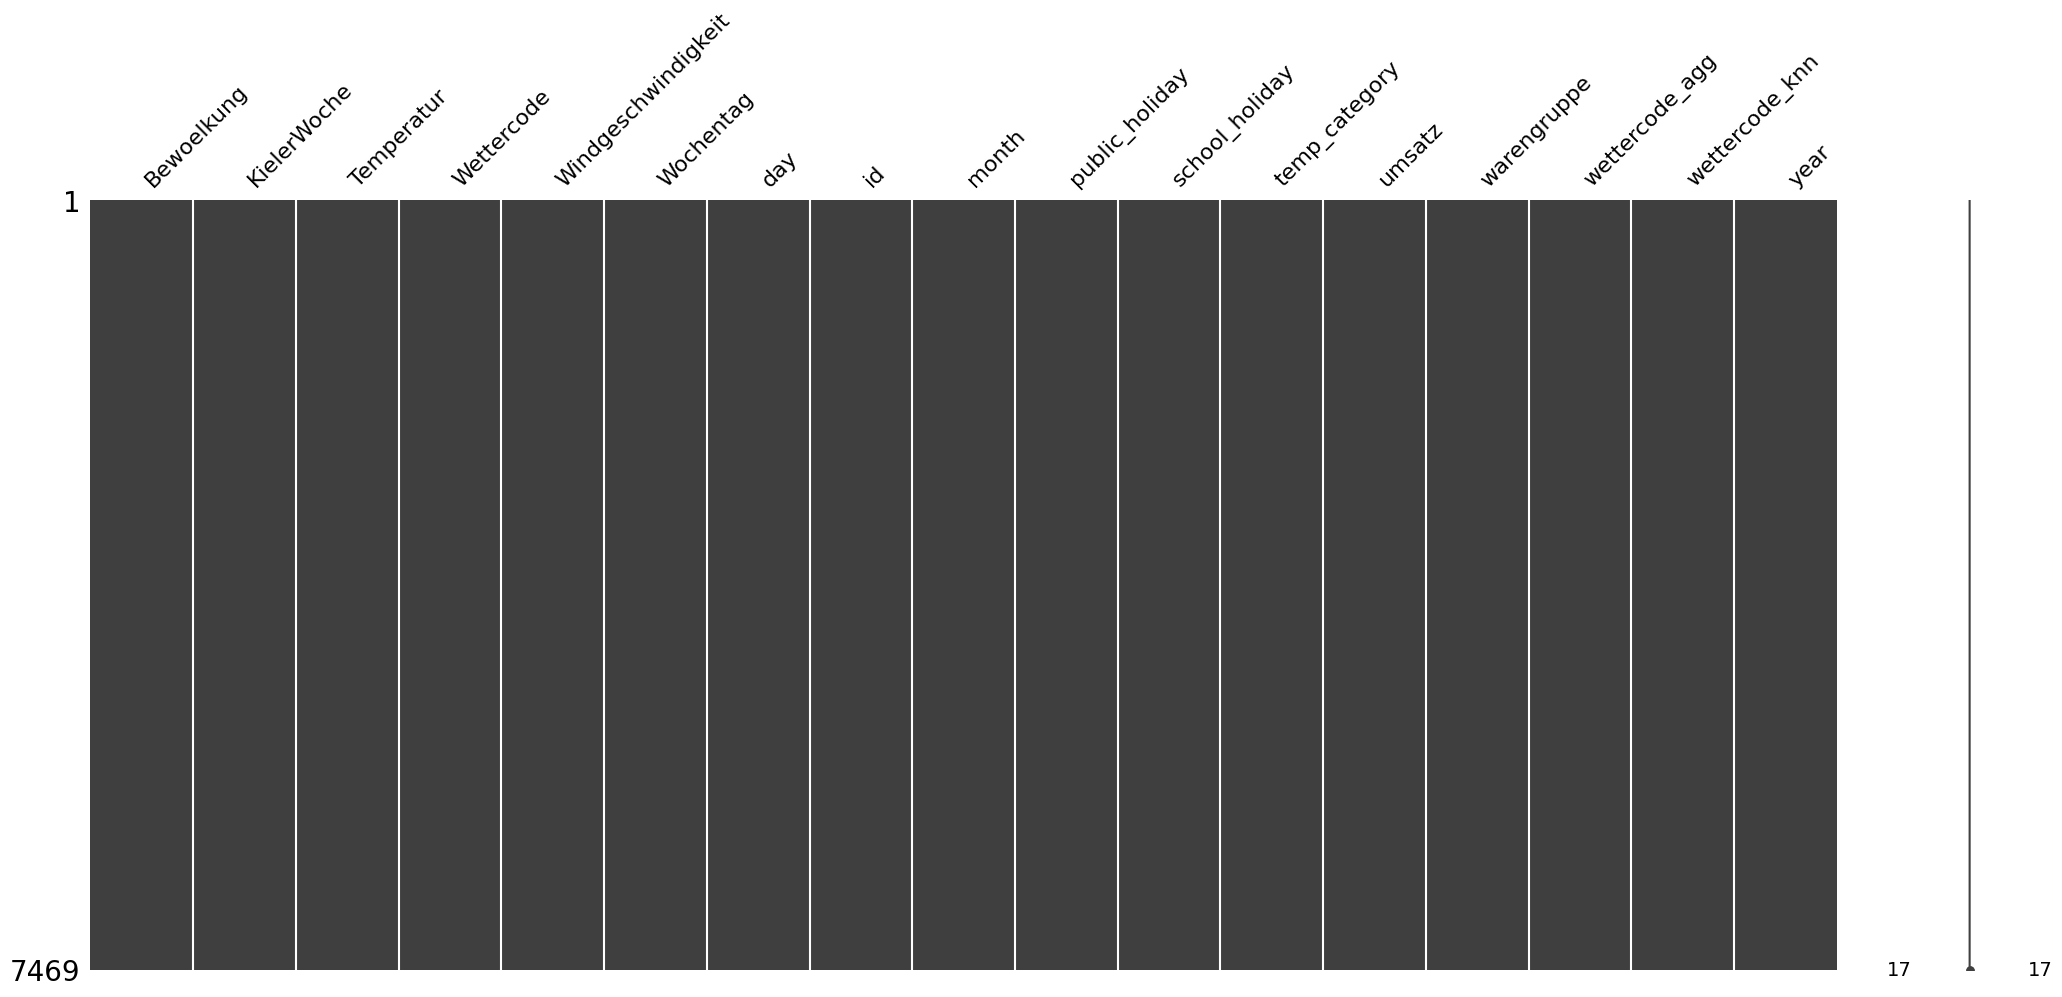

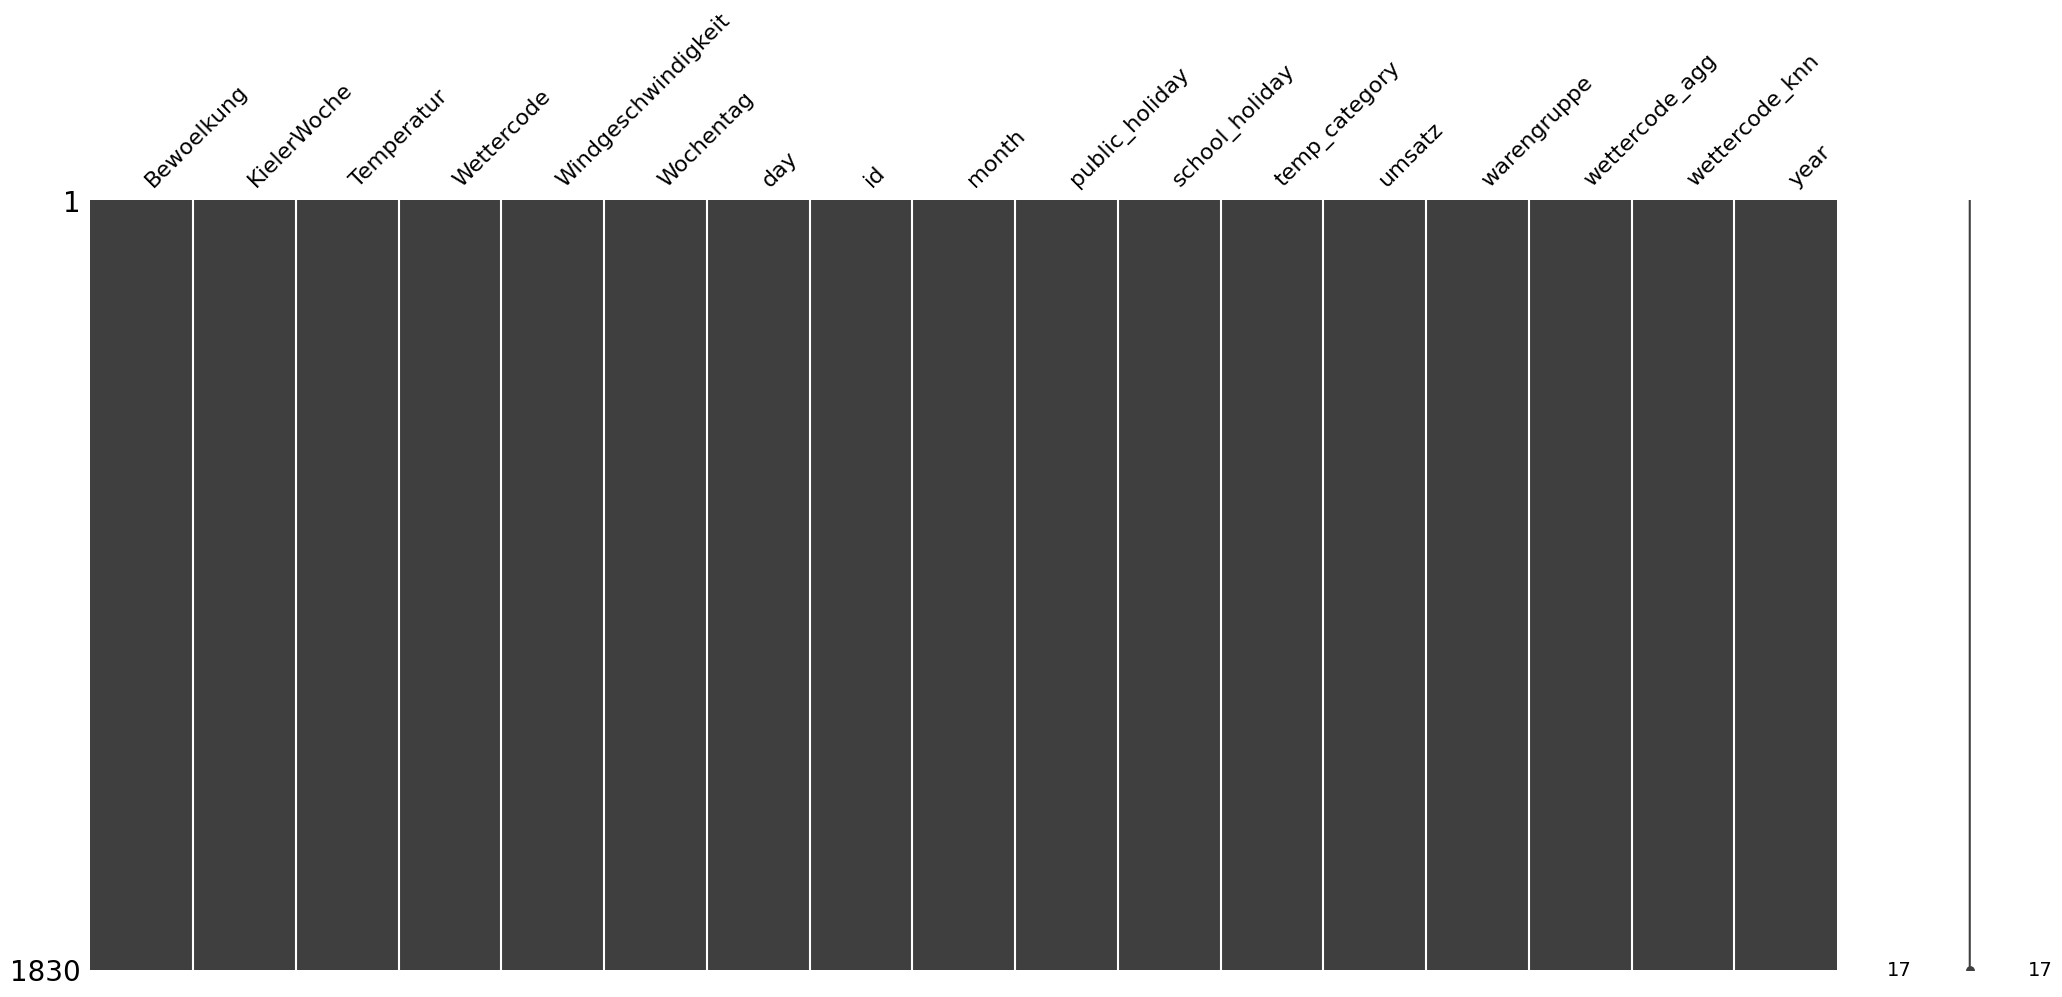

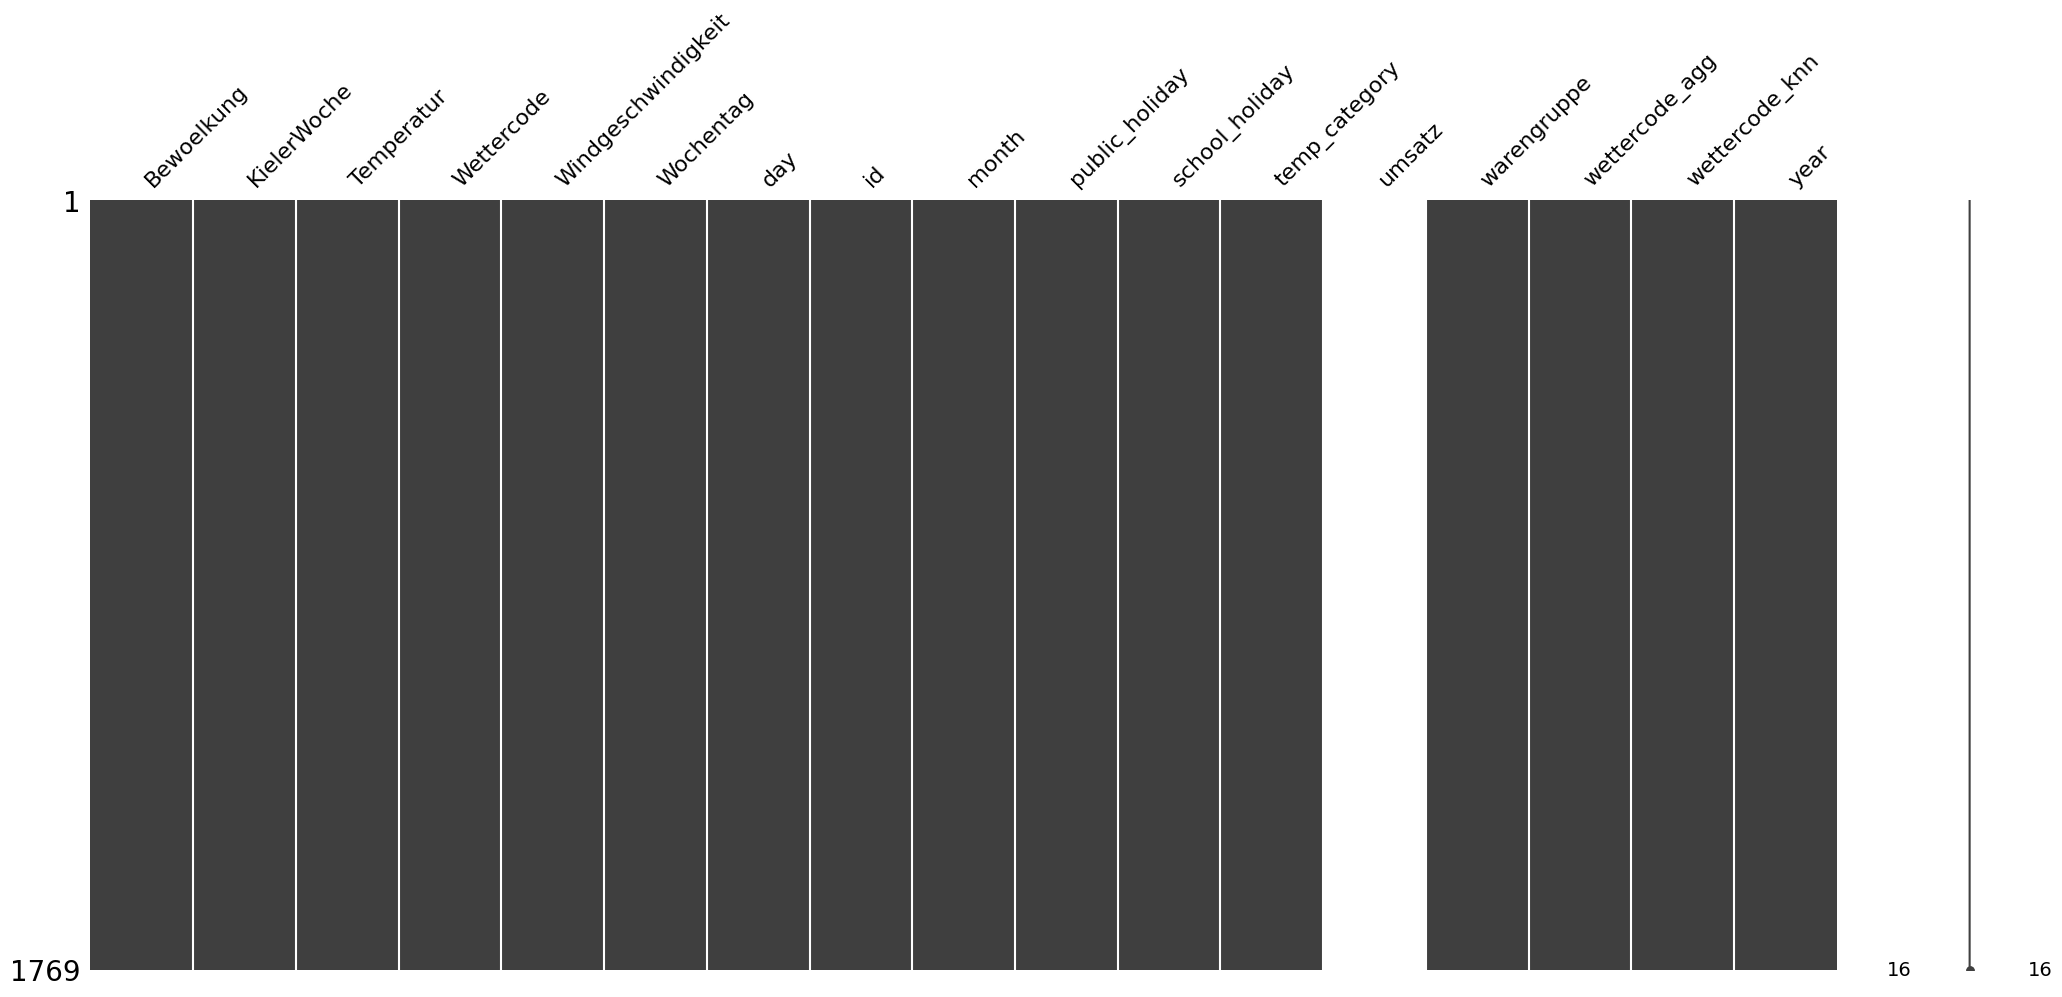

In [41]:
import missingno as msno
import matplotlib.pyplot as plt

for df in [train_df, val_df, test_df]:
    
    msno.matrix(df)
    plt.show()

In [16]:
#prepare data
X_train = train_df.drop(columns=['umsatz'])
y_train = train_df['umsatz']
X_val = val_df.drop(columns=['umsatz'])
y_val = val_df['umsatz']
X_test = test_df.drop(columns=['umsatz'])
y_test = test_df['umsatz']

#for getting better in small umsatz values, apply log1p transformation to the target variable
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [17]:
#define model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.005, l2=0.005), input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001)), #add L2 regularization to prevent overfitting (in first row bigger weihg than here in second row)
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.summary()
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

c:\Users\julia\Documents\Uni_lokal\ML\Repositories\venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,417 (48.50 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#train model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
history = model.fit(X_train_scaled, y_train_log, epochs=500, batch_size=32, validation_data=(X_val_scaled, y_val_log))

Epoch 1/500
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4.9509 - mae: 1.2741 - val_loss: 2.5459 - val_mae: 0.7333
Epoch 2/500
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4487 - mae: 0.7693 - val_loss: 1.7826 - val_mae: 0.5396
Epoch 3/500
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9529 - mae: 0.6996 - val_loss: 1.4525 - val_mae: 0.5337
Epoch 4/500
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5417 - mae: 0.6450 - val_loss: 1.1527 - val_mae: 0.5157
Epoch 5/500
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2455 - mae: 0.6183 - val_loss: 0.9793 - val_mae: 0.5253
Epoch 6/500
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0186 - mae: 0.5959 - val_loss: 0.7802 - val_mae: 0.5115
Epoch 7/500
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8755 - mae: 0.5967 - val_loss: 0.6563 - val_mae: 0.5039
Epoch 8/500
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7395 - mae: 0.5779 - val_loss: 0.5533 - val_mae: 0.4901
Epoch 9/500
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

In [19]:
#evaluate model
val_loss, val_mae = model.evaluate(X_val_scaled, y_val_log)
print(f'Validation MAE: {val_mae}')

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1652 - mae: 0.2509
Validation MAE: 0.2508607506752014


In [20]:
#save model
model.save('trained_model_regression.h5')

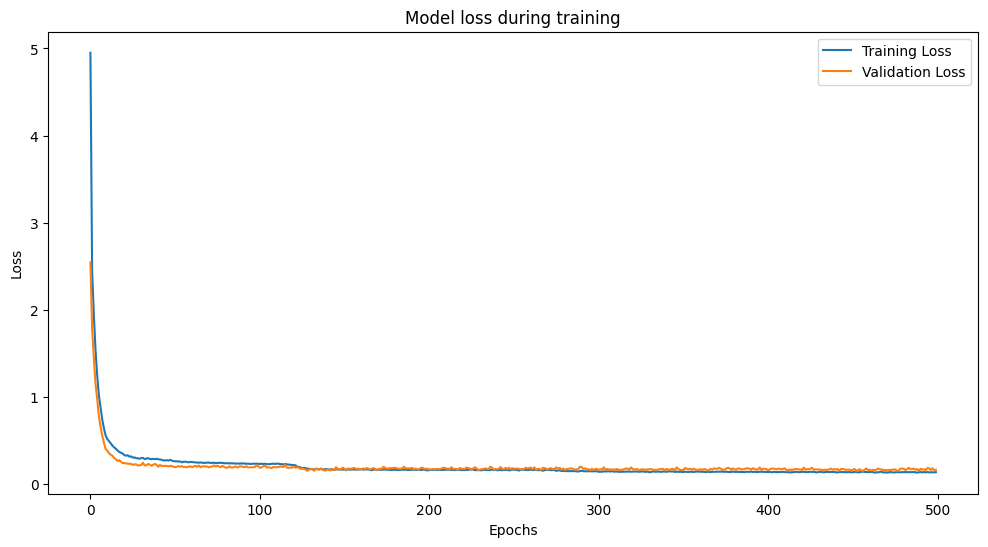

In [21]:
#plotting training history
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss during training')
plt.legend()
plt.show()

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE: 0.127, MAE: 0.251, R2: 0.686


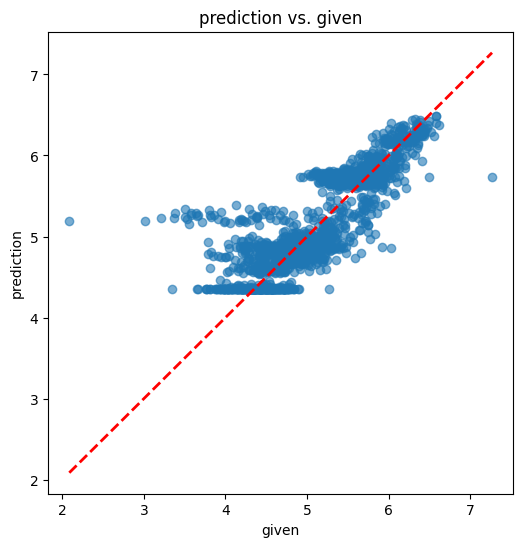

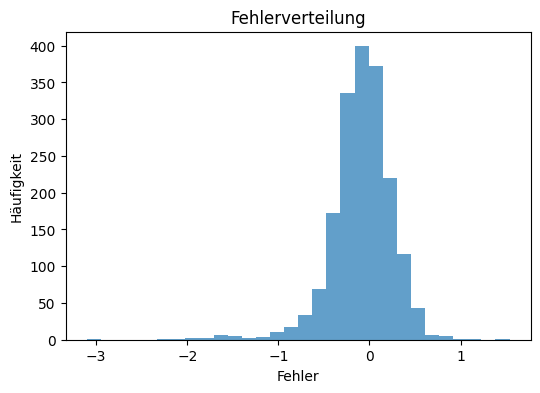

In [22]:
#visualize training history
import matplotlib.pyplot as plt

#predictions
predictions = model.predict(X_val_scaled).flatten()
mse = mean_squared_error(y_val_log, predictions)
mae = mean_absolute_error(y_val_log, predictions)
r2 = r2_score(y_val_log, predictions)

print(f"MSE: {mse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

#scatter
plt.figure(figsize=(6,6))
plt.scatter(y_val_log, predictions, alpha=0.6)
plt.plot([y_val_log.min(), y_val_log.max()],
         [y_val_log.min(), y_val_log.max()],
         'r--', lw=2)
plt.xlabel("given")
plt.ylabel("prediction")
plt.title("prediction vs. given")
plt.show()

# Fehlerverteilung
errors = y_val_log.values - predictions
plt.figure(figsize=(6,4))
plt.hist(errors, bins=30, alpha=0.7)
plt.xlabel("Fehler")
plt.ylabel("Häufigkeit")
plt.title("Fehlerverteilung")
plt.show()


MSE (Originalskala): 4422.974
MAE (Originalskala): 45.632
R² (Originalskala): 0.739


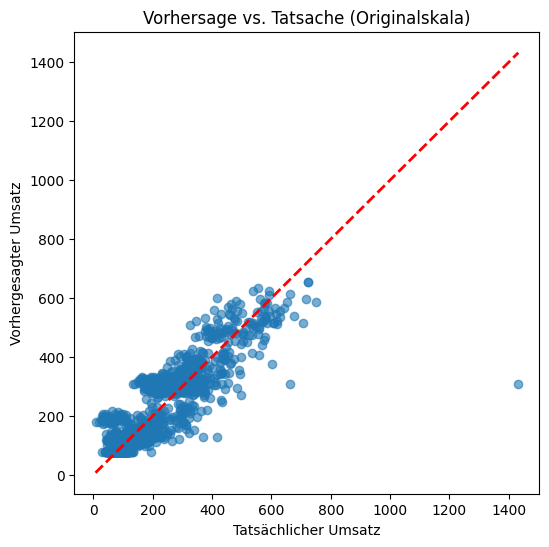

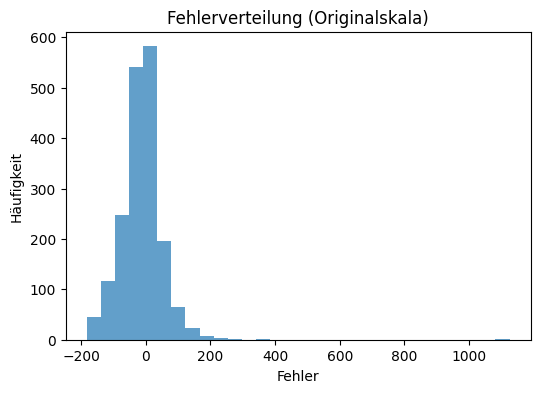

In [23]:
# Rücktransformation der Predictions in die Originalskala
predictions_original = np.expm1(predictions)  # Predictions zurück in Umsatz-Skala

# Metriken in Originalskala berechnen
mse_original = mean_squared_error(y_val, predictions_original)
mae_original = mean_absolute_error(y_val, predictions_original)
r2_original = r2_score(y_val, predictions_original)

print(f"MSE (Originalskala): {mse_original:.3f}")
print(f"MAE (Originalskala): {mae_original:.3f}")
print(f"R² (Originalskala): {r2_original:.3f}")

# Scatter-Plot in Originalskala
plt.figure(figsize=(6,6))
plt.scatter(y_val, predictions_original, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         'r--', lw=2)
plt.xlabel("Tatsächlicher Umsatz")
plt.ylabel("Vorhergesagter Umsatz")
plt.title("Vorhersage vs. Tatsache (Originalskala)")
plt.show()

# Fehlerverteilung in Originalskala
errors_original = y_val.values - predictions_original
plt.figure(figsize=(6,4))
plt.hist(errors_original, bins=30, alpha=0.7)
plt.xlabel("Fehler")
plt.ylabel("Häufigkeit")
plt.title("Fehlerverteilung (Originalskala)")
plt.show()

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 4422.97
MAE: 45.63
R² : 0.739


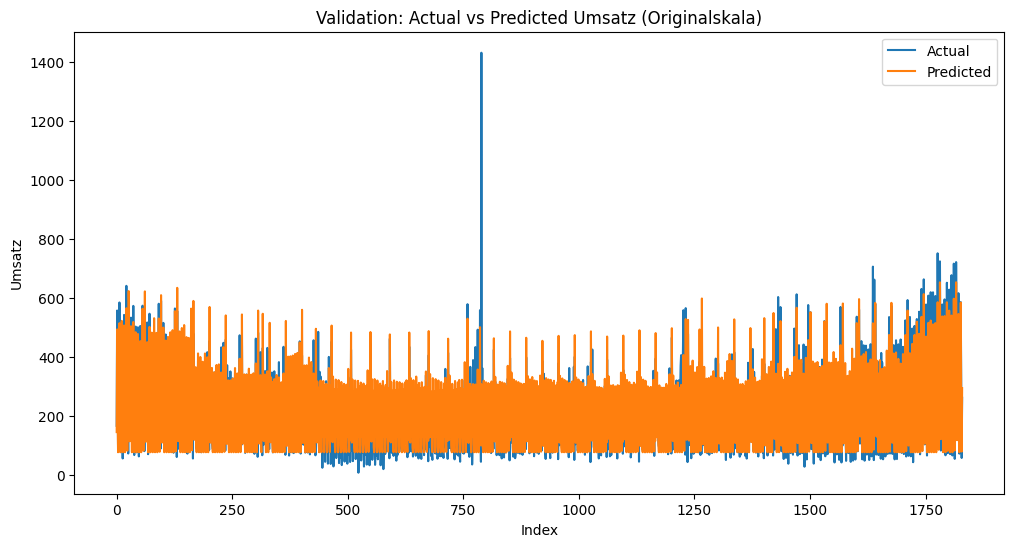

In [24]:
#predictions
future_df = X_val.copy()  #using validation data as example for future data, already without "umsatz"

X_future_scaled = scaler.transform(future_df)
future_predictions = model.predict(X_future_scaled).flatten()

# Rücktransformation in Originalskala
future_predictions_original = np.expm1(future_predictions)
future_df['predicted_umsatz'] = future_predictions_original

#comparison with actual values
mse = mean_squared_error(y_val, future_predictions_original)
mae = mean_absolute_error(y_val, future_predictions_original)
r2  = r2_score(y_val, future_predictions_original)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² : {r2:.3f}")

#visualize future predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_val.values, label='Actual')
plt.plot(future_predictions_original, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Umsatz')
plt.title('Validation: Actual vs Predicted Umsatz (Originalskala)')
plt.legend()
plt.show()

234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE on the Training Data: 29.87%
MAPE on the Validation Data: 32.26%
MAE on the Training Data: 44.24
MAE on the Validation Data: 45.63


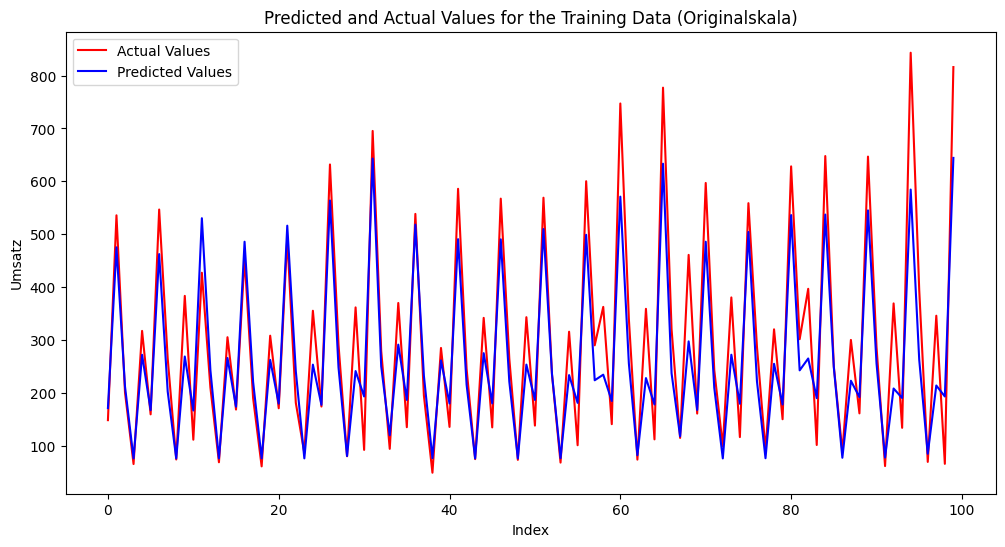

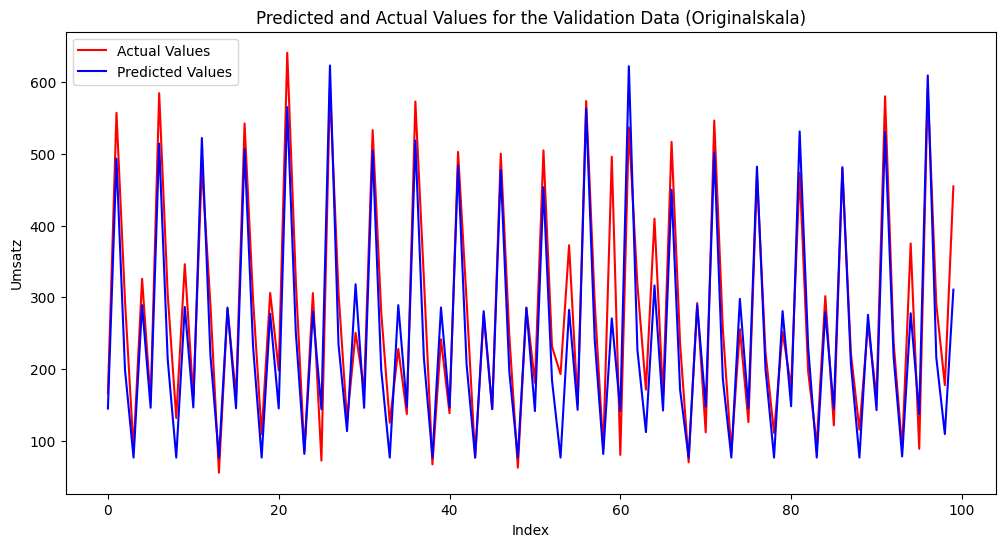

In [25]:
#visualizing results
training_features = X_train_scaled
training_labels = y_train_log
validation_features = X_val_scaled
validation_labels = y_val_log

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)

# Rücktransformation in Originalskala
training_predictions_original = np.expm1(training_predictions).flatten()
validation_predictions_original = np.expm1(validation_predictions).flatten()

print(f"MAPE on the Training Data: {mape(y_train, training_predictions_original):.2f}%")
print(f"MAPE on the Validation Data: {mape(y_val, validation_predictions_original):.2f}%")

mae_train = mean_absolute_error(y_train, training_predictions_original)
mae_val   = mean_absolute_error(y_val, validation_predictions_original)
print(f"MAE on the Training Data: {mae_train:.2f}")
print(f"MAE on the Validation Data: {mae_val:.2f}")

def plot_predictions(predictions, actual, title, dates=None):
    """
    Plots predicted vs. actual values.

    predictions : np.array oder pd.Series
        Vorhersagen des Modells
    actual : np.array oder pd.Series
        Tatsächliche Werte
    title : str
        Titel des Plots
    dates : pd.Series oder None
        Optional: Datumswerte für X-Achse
    """
    plt.figure(figsize=(12, 6))
    
    if dates is not None:
        x_axis = dates
        plt.plot(x_axis, actual, label='Actual Values', color='red')
        plt.plot(x_axis, predictions, label='Predicted Values', color='blue')
    else:
        x_axis = range(len(actual))
        plt.plot(x_axis, actual, label='Actual Values', color='red')
        plt.plot(x_axis, predictions, label='Predicted Values', color='blue')
    
    plt.title(title)
    plt.xlabel('Date' if dates is not None else 'Index')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()


# Create DataFrames with original values
data_train = pd.DataFrame({'prediction': training_predictions_original, 'actual': y_train})
data_validation = pd.DataFrame({'prediction': validation_predictions_original, 'actual': y_val})

# Plot first 100 cases for training
plot_predictions(data_train['prediction'].head(100), 
                 data_train['actual'].head(100), 
                 'Predicted and Actual Values for the Training Data (Originalskala)')

# Plot first 100 cases for validation
plot_predictions(data_validation['prediction'].head(100), 
                 data_validation['actual'].head(100), 
                 'Predicted and Actual Values for the Validation Data (Originalskala)')